<div align='left'><font size='6' color='#5b2c6f '> Purpose of Notebook</font></div>


### Building a NLP model to predict which brand a new product should be assigned.

- [Functions](#1)
- [Import Packages](#2)
- [Explore Data](#3)
- [Manipulate Data](#4)
- [Clean up text](#5)

## [Functions](#1)<a id='1'></a>

In [483]:
def check_dataset(df):
    """ check missing value and unique number of category
    """
    print(f'Dataset shape: {df.shape}')
    print('==========================')
    plt.figure(figsize = (10,5))
    df.isna().sum().plot(kind = 'bar',rot = 45)
    plt.title('missing value count')
    for c in df.columns:
        unique = len(df[c].unique())
        print(f'{c}: unique - > {unique}.')
# ===========================================================================================================
def lemmatize_sentence(sentence):
    # tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence
# ===========================================================================================================
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
# ===========================================================================================================
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

## [Import Packages](#2)<a id='2'></a>

In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize 
from typing import List
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import keras
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangsun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yangsun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yangsun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## [Explore data](#3)<a id='3'></a>

In [568]:
# read in data
behold_brand = pd.read_csv('../../data/behold_brands USC.csv')
behold_product = pd.read_excel('../../data/Behold+product+data+04262021.xlsx')
outfit_combo = pd.read_csv('../../data/outfit_combinations USC.csv')
tags = pd.read_csv('../../data/usc_additional_tags USC.csv')
print(f'''
Brand shape: {behold_brand.shape}.
Product shape: {behold_product.shape}.
Outfit shape: {outfit_combo.shape}.
Tags shaape: {tags.shape}.
''')


Brand shape: (162, 10).
Product shape: (61355, 11).
Outfit shape: (5291, 5).
Tags shaape: (97420, 4).



<div align='left'><font size='4' color='#229954'>Explore behold brand dataset</font></div>

Dataset shape: (162, 10)
brand_id: unique - > 74.
brand: unique - > 74.
brand_value: unique - > 7.
bio: unique - > 72.
quote: unique - > 72.
quote_attribute: unique - > 60.
intro: unique - > 71.
lifestyle_copy: unique - > 67.
short_bio: unique - > 72.
listing_bio: unique - > 72.


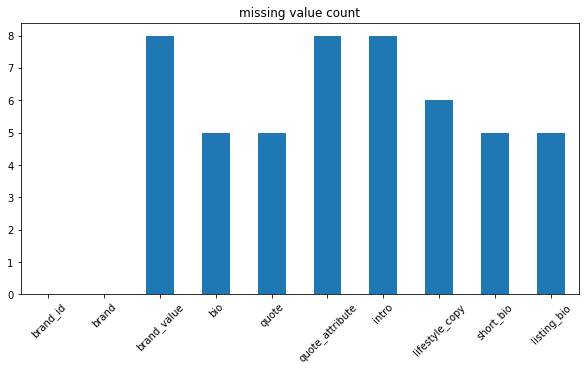

In [569]:
# check dataset
check_dataset(behold_brand)

<div align='left'><font size='4' color='#229954'>Explore behold product dataset</font></div>

Dataset shape: (61355, 11)
product_id: unique - > 61355.
brand: unique - > 386.
brand_category: unique - > 633.
name: unique - > 42616.
details: unique - > 7035.
created_at: unique - > 61349.
brand_canonical_url: unique - > 58156.
description: unique - > 42211.
brand_description: unique - > 42551.
brand_name: unique - > 42603.
product_active: unique - > 2.


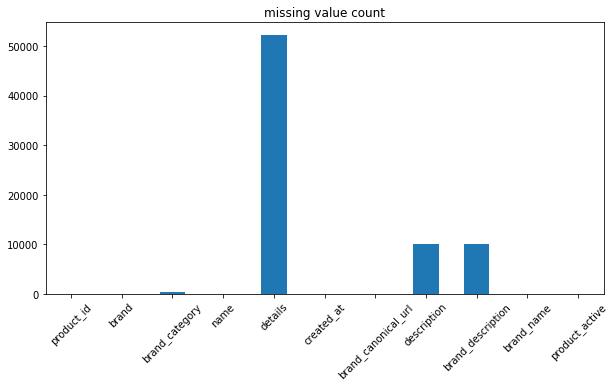

In [189]:
check_dataset(behold_product)

Text(0.5, 1.0, 'Top 30 brands data point count')

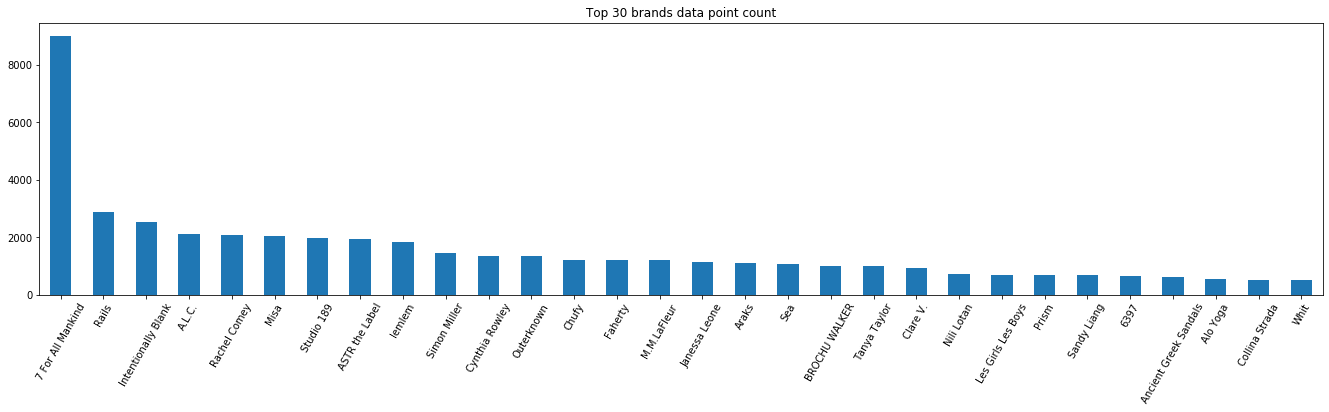

In [190]:
# check number of brands
plt.figure(figsize = (23,5))
behold_product['brand'].value_counts()[:30].plot(kind = 'bar',rot = 60)
plt.title('Top 30 brands data point count')

In [191]:
top_30_brands_count = behold_product['brand'].value_counts()[:30].sum()
print(f'Top 30 brands take about {round(top_30_brands_count/behold_product.shape[0],2)*100} percentage of product dataset.')

Top 30 brands take about 75.0 percentage of product dataset.


Text(0.5, 1.0, 'is active')

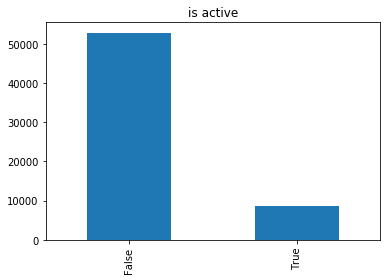

In [192]:
behold_product['product_active'].value_counts().plot(kind = 'bar')
plt.title('is active')

In [193]:
# check both missing and unknown
for c in behold_product.columns:
    blank = behold_product[c].isna().sum()
    temp = [str(r).lower()=='unknown' for r in behold_product[c]]
    unknown  = sum(temp)
    print(f'{c} -> blank:{blank}, unknow:{unknown}')

product_id -> blank:0, unknow:0
brand -> blank:0, unknow:0
brand_category -> blank:459, unknow:53249
name -> blank:1, unknow:0
details -> blank:52155, unknow:0
created_at -> blank:0, unknow:0
brand_canonical_url -> blank:0, unknow:0
description -> blank:10117, unknow:0
brand_description -> blank:10121, unknow:0
brand_name -> blank:1, unknow:0
product_active -> blank:0, unknow:0


There are 53249 unknown values for `brand category` column, so this column is not very useful.

<div align='left'><font size='4' color='#229954'>Explore Outfit dataset</font></div>

Dataset shape: (5291, 5)
outfit_id: unique - > 1137.
product_id: unique - > 804.
outfit_item_type: unique - > 7.
brand: unique - > 306.
product_full_name: unique - > 799.


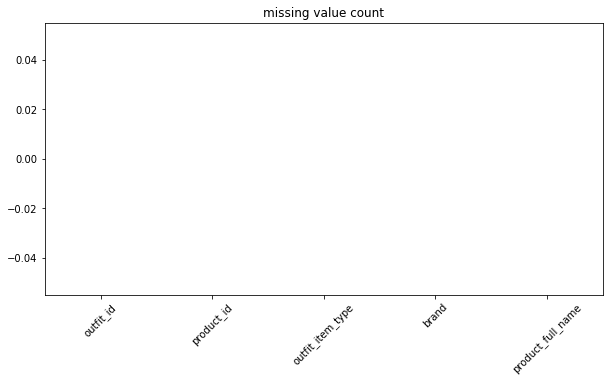

In [194]:
check_dataset(outfit_combo)

<div align='left'><font size='4' color='#229954'>Explore tags dataset</font></div>

Dataset shape: (97420, 4)
product_id: unique - > 3970.
product_color_id: unique - > 5517.
attribute_name: unique - > 86.
attribute_value: unique - > 456.


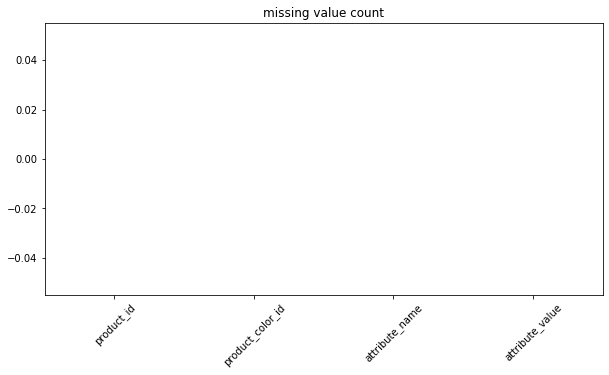

In [64]:
check_dataset(tags)

## [Manipulate data](#4)<a id='4'></a>

Use Behold product dataset as the master dataset, and left join with outfit combo dataset to the product dataset by `product ID`.<br>
I did not left join with `tags` dataset because `tags` dataset creates too many duplicated rows. 

In [195]:
behold_product_master = pd.merge(behold_product, outfit_combo,how = 'left',on='product_id',suffixes=('_product_df','_outfit_df'))
behold_product_master.shape

(65785, 15)

Dataset shape: (65785, 15)
product_id: unique - > 61355.
brand_product_df: unique - > 386.
brand_category: unique - > 633.
name: unique - > 42616.
details: unique - > 7035.
created_at: unique - > 61349.
brand_canonical_url: unique - > 58156.
description: unique - > 42211.
brand_description: unique - > 42551.
brand_name: unique - > 42603.
product_active: unique - > 2.
outfit_id: unique - > 1134.
outfit_item_type: unique - > 8.
brand_outfit_df: unique - > 304.
product_full_name: unique - > 766.


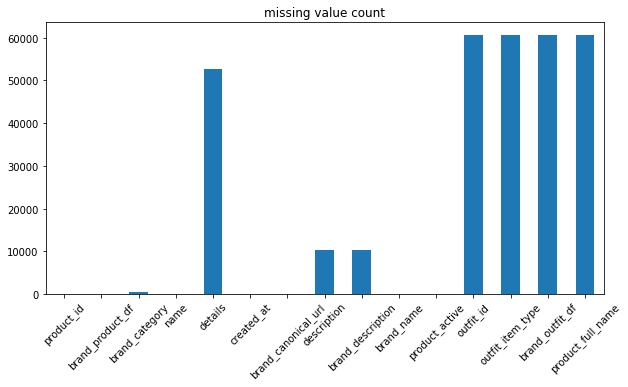

In [198]:
# explore master dataset
check_dataset(behold_product_master)

There is no additional information to the dataset by left joining `outfit combo` dataset to `product` dataset, because the column from `outfit combo` dataset has lots of missing value when left join to `Product` dataset. Therefore, I decided just to use `Product` dataset for classification problem. 

In [534]:
behold_product_orig = behold_product.copy()

Dataset shape: (61355, 11)
product_id: unique - > 61355.
brand: unique - > 386.
brand_category: unique - > 633.
name: unique - > 42616.
details: unique - > 7035.
created_at: unique - > 61349.
brand_canonical_url: unique - > 58156.
description: unique - > 42211.
brand_description: unique - > 42551.
brand_name: unique - > 42603.
product_active: unique - > 2.


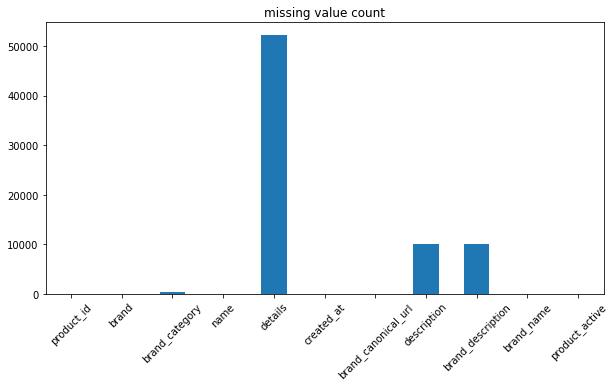

In [289]:
check_dataset(behold_product)

### Clean up data Fill out missing values
- Since details column has lots of missing value, the column by itself might not be useful. I decided to concat with description to create a new column called `details_description`.
- more than 50K missing or unknown value under `brand_category`, I will fill out all missing value(nan) with Unknown.
- `name` and `brand_name` are same information, I will drop `brand_name` column.
- drop `product_id`
- drop `created_at` column.
- drop `brand_canonical_url` column.
- drop `product_active` column.

In [570]:
# fill details and description missing value with Unkown
behold_product['details'] = behold_product['details'].fillna('Unknown')
behold_product['description'] = behold_product['description'].fillna('Unknown')

In [571]:
# concat details and description column.
behold_product['details_description'] = behold_product['details'].astype(str) + ' '+ behold_product['description'].astype(str)

In [572]:
# fill nan with Unknown for brand_category column
behold_product['brand_category'] = behold_product['brand_category'].fillna('Unknwon')
behold_product['name'] = behold_product['name'].fillna('Unknwon')

In [573]:
# drop brand_name, created_at, brand_cononical_url, product_active columns
behold_product.drop(['product_id','brand_name','created_at','brand_canonical_url','product_active','details','description','brand_description'], axis =1, inplace = True)

In [574]:
behold_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61355 entries, 0 to 61354
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                61355 non-null  object
 1   brand_category       61355 non-null  object
 2   name                 61355 non-null  object
 3   details_description  61355 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


### Now data has three descriptive columns to predict brand column.

## [Clean up Text](#5)<a id='5'></a>

<div align='left'><font size='4' color='#229954'>Text Cleaning
</font></div>

- Remove `\n` in all text, replace with blank.
- replace `\` with blank, as it separates words.
- lower all cases

In [575]:
for c in behold_product.columns[1:]:
    behold_product[c] = [str(r).replace('\n',' ') for r in behold_product[c]]
    behold_product[c] = [str(r).replace("/", ' ') for r in behold_product[c]]
    behold_product[c] = [str(r).lower() for r in behold_product[c]]

In [576]:
behold_product_1 = behold_product.copy()
behold_product.head(2)

,brand,brand_category,name,details_description
0,Two,unknown,khadi stripe shirt-our signature shirt,unknown our signature khadi shirt available in...
1,Collina Strada,unknown,ruffle market dress loopy pink sistine tomato,unknown mid-length dress with ruffles and adju...


<div align='left'><font size='4' color='#229954'>Remove Stopwords and Lemmatization
</font></div>

In [577]:
stop_words = list(set(stopwords.words('english')))

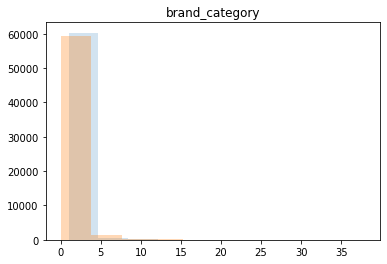

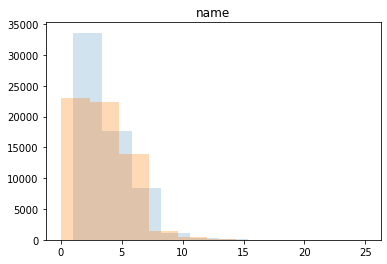

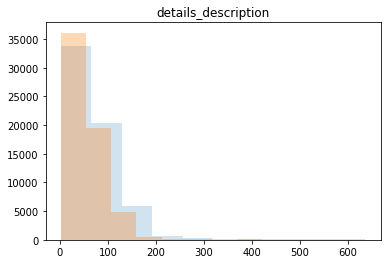

In [578]:
# remove stopwords
for c in behold_product.columns[1:]:
    col, bef, aft = [],[],[]
    for r in behold_product[c]:
        word_tokens = word_tokenize(r) 
        bef.append(len(word_tokens))
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        aft.append(len(filtered_sentence))
        col.append(' '.join(filtered_sentence))
    
    # plot length before and after remove stop words
    plt.hist(bef, alpha = 0.2)
    plt.hist(aft, alpha = 0.3)
    plt.title(c)
    plt.show()
    behold_product[c] = col

In [582]:
# lemmatization
for c in behold_product.columns[1:]:
    behold_product[c] = [' '.join(lemmatize_sentence(r)) for r in behold_product[c]]
behold_product.head(2)

,brand,brand_category,name,details_description
0,Two,unknown,khadi stripe shirt-our signature shirt,unknown signature khadi shirt available black ...
1,Collina Strada,unknown,ruffle market dress loopy pink sistine tomato,unknown mid-length dress ruffle adjustable str...


In [ ]:
stopwords_removed_lemmaed_docs = [' '.join(lemmatize_sentence(r)) for r in stopwords_removed_docs]

<div align='left'><font size='4' color='#229954'>Tokenization
</font></div>

In [586]:
# only look at most frequency 200 words
num_words_look = 200
tokenizer = Tokenizer(num_words=num_words_look, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(list(behold_product['details_description']))

In [588]:
# integer encode the documents
encoded_docs = integer_encode_documents(list(behold_product['details_description']), tokenizer)
# see some lengths of the documents
list(map(len, encoded_docs))[:20]

[53, 34, 8, 7, 2, 21, 27, 22, 25, 19, 20, 16, 23, 33, 27, 60, 62, 64, 52, 50]

In [590]:
MAX_SEQUENCE_LENGTH = 128
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
padded_docs.shape

(61355, 128)

<div align='left'><font size='4' color='#229954'>Create Labels
</font></div>

I will create total 31 categories for label. Top 30 brands + others

In [633]:
new_label = list(behold_product['brand'].value_counts().index)[:30]
labels = [l if l in new_label else 'others'for l in behold_product['brand']]

In [634]:
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [608]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

In [610]:
## Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('../../../glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [611]:
# label embedding
# create a weight matrix for words in training docs
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [636]:
def make_lstm_classification_model(plot=False):
    model =  keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=128, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(31, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [637]:
model = make_lstm_classification_model()
model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 128, 100)          3259500   
_________________________________________________________________
masking_3 (Masking)          (None, 128, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_7 (Dense)              (None, 31)                527       
Total params: 3,379,339
Trainable params: 119,839
Non-trainable params: 3,259,500
_________________________________________________________________


In [638]:
results = model.fit(X_train, y_train,validation_split = 0.02, epochs=10, verbose=1)

Epoch 1/10
1504/1504 [==============================] - 287s 191ms/step - loss: 1.0872 - accuracy: 0.7209 - val_loss: 0.9131 - val_accuracy: 0.7678
Epoch 2/10
1504/1504 [==============================] - 291s 193ms/step - loss: 0.5617 - accuracy: 0.8551 - val_loss: 0.5412 - val_accuracy: 0.8554
Epoch 3/10
1504/1504 [==============================] - 326s 217ms/step - loss: 0.4547 - accuracy: 0.8810 - val_loss: 0.4976 - val_accuracy: 0.8697
Epoch 4/10
1504/1504 [==============================] - 280s 186ms/step - loss: 0.3969 - accuracy: 0.8961 - val_loss: 0.4526 - val_accuracy: 0.8859
Epoch 5/10
1504/1504 [==============================] - 298s 198ms/step - loss: 0.3588 - accuracy: 0.9071 - val_loss: 0.4238 - val_accuracy: 0.8839
Epoch 6/10
1504/1504 [==============================] - 308s 205ms/step - loss: 0.3287 - accuracy: 0.9150 - val_loss: 0.4265 - val_accuracy: 0.8910
Epoch 7/10
1504/1504 [==============================] - 273s 181ms/step - loss: 0.3103 - accuracy: 0.9193 - val_

In [639]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 16s 41ms/step - loss: 0.4164 - accuracy: 0.8956
Accuracy: 89.560753


In [417]:
behold_product['brand_category'] = [r.lower() for r in behold_product['brand_category']]
behold_product['name'] = [str(r).lower() for r in behold_product['name']]
behold_product['details_description'] = [str(r).lower() for r in behold_product['details_description']]
behold_product.head(2)

,brand,brand_category,name,details_description
0,Two,unknown,khadi stripe shirt-our signature shirt,nanour signature khadi shirt\navailable in bla...
1,Collina Strada,unknown,ruffle market dress loopy pink sistine tomato,nanmid-length dress with ruffles and adjustabl...


In [468]:
behold_product['details_description'][0]

'Unknown Our signature khadi shirt\navailable in black and white\nEasy to wear from beach to city. We promise this top will be your go-to warm\nweather item. Perfect under a blazer. Hand loomed woven stripe in khadi cotton.\n Slightly sheer and gets softer with every wash. Ships First week of April\nCOLOR: WHITE OR BLACK\n—  Length 27"  and  Width  26.5" —  One size fits most —  Grid khadi cotton'

In [428]:
behold_product['details_description'][40]

'nana feminine update to the maxi shirt dress, the adriana is cut from a breezy tile\nprint cotton blend on navy ground. featuring a full button front and fold-over\ncollar with tie waist. long sleeves taper into a slight balloon elasticated\ncuff. a wide ruffle hem finishes off this chic ankle-grazing silhouette.\nmade in the usa \ndry clean\n51% rayon 49% cotton\nmodel measurements: height 5\'9", waist 24, bust 32, hips 34\nmodel is wearing size xs'

In [435]:
d = {len(r):r for r in behold_product['brand_category']}
d[340]

'handbags/handbags/tophandlessatchels,jewelryaccessories/accessories/walletscaseskeyrings/walletswristlets,handbags/handbags/walletscases2/walletswristlets,thebarneysedit19/womens1/handbags3,giftsjsholiday/valentinesdaygiftguide20/giftsforhervalentines/galentinesday,giftsjsholiday/valentinesdaygiftguide20/giftsforhervalentines/antiromantic'

In [270]:
# # drop brand category column
# behold_product.drop(['brand_category'], inplace = True, axis = 1)

# # fill missing description with details
# missing_desc = behold_product.isna().sum()['description']
# print(f'there are {missing_desc} missing for description column')
# # ==================================================================================================
# behold_product.loc[behold_product['description'].isna(),'description'] = behold_product.iloc[np.where(behold_product['description'].isna())[0],3]
# missing_desc = behold_product.isna().sum()['description']
# print(f'there are {missing_desc} missing for description column now.')

# # continue to fill missing value based on name 
# d = {}
# for i,v in enumerate(behold_product['name']):
#     if v not in d and behold_product.iloc[i,6]==behold_product.iloc[i,6]:
#         d[v]=behold_product.iloc[i,6]
# # ==================================================================================================
# for i,v in enumerate(behold_product['description']):
#     if v!=v:
#         try:
#             behold_product.iloc[i,6] = d[behold_product.iloc[i,2]]
#         except:None
# # ==================================================================================================
# missing_desc = behold_product.isna().sum()['description']
# print(f'there are {missing_desc} missing for description column now.')

# # continue fill missing value based on brand
# d = {}
# for i,v in enumerate(behold_product['brand']):
#     if v not in d and behold_product.iloc[i,6]==behold_product.iloc[i,6]:
#         d[v]=behold_product.iloc[i,6]
# # ==================================================================================================
# for i,v in enumerate(behold_product['description']):
#     if v!=v:
#         try:
#             behold_product.iloc[i,6] = d[behold_product.iloc[i,1]]
#         except:None
# # ==================================================================================================
# missing_desc = behold_product.isna().sum()['description']
# print(f'there are {missing_desc} missing for description column now.')

In [334]:
# drop brand_description column as it is a duplicated column
behold_product.drop(['brand_description'], inplace = True, axis = 1)

In [335]:
# drop brand_canonical_url column
behold_product.drop(['brand_canonical_url'], inplace = True, axis = 1)

In [336]:
# drop details column
behold_product.drop(['details'], inplace = True, axis = 1)

In [337]:
behold_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61355 entries, 0 to 61354
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           61355 non-null  object
 1   brand                61355 non-null  object
 2   brand_category       60896 non-null  object
 3   name                 61354 non-null  object
 4   created_at           61355 non-null  object
 5   description          51238 non-null  object
 6   brand_name           61354 non-null  object
 7   product_active       61355 non-null  bool  
 8   details_description  61355 non-null  object
dtypes: bool(1), object(8)
memory usage: 3.8+ MB


In [278]:
# drop name and brand_name column
behold_product.dropna(axis = 1, inplace = True)

In [284]:
behold_product.head()

,product_id,brand,created_at,description,product_active
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,2021-01-27 01:17:19.305 UTC,Our signature khadi shirt\navailable in black ...,True
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,2021-03-09 18:43:10.457 UTC,Mid-length dress with ruffles and adjustable s...,True
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,2021-02-10 02:58:59.591 UTC,IBI Slip On Raw Red Knit Sneaker Women,False
3,01EY50E27A0P5V6KCW01XPDB43,Cariuma,2021-02-10 03:40:52.842 UTC,IBI Slip On Black Knit Sneaker Women,False
4,01EY6DWHC2W5HPNEGXKEJ4A1CX,Cariuma,2021-02-10 16:55:13.024 UTC,IBI Slip On Raw Red Knit Sneaker Women,False
